In [12]:
import os
import PIL
from PIL import Image
import numpy as np
import json
from torch.utils.data import Dataset, DataLoader
import itertools
from torchvision import datasets, transforms, models
from custom_transform import ThresholdTransform,AddNoise,DetachWhite

# Image Open

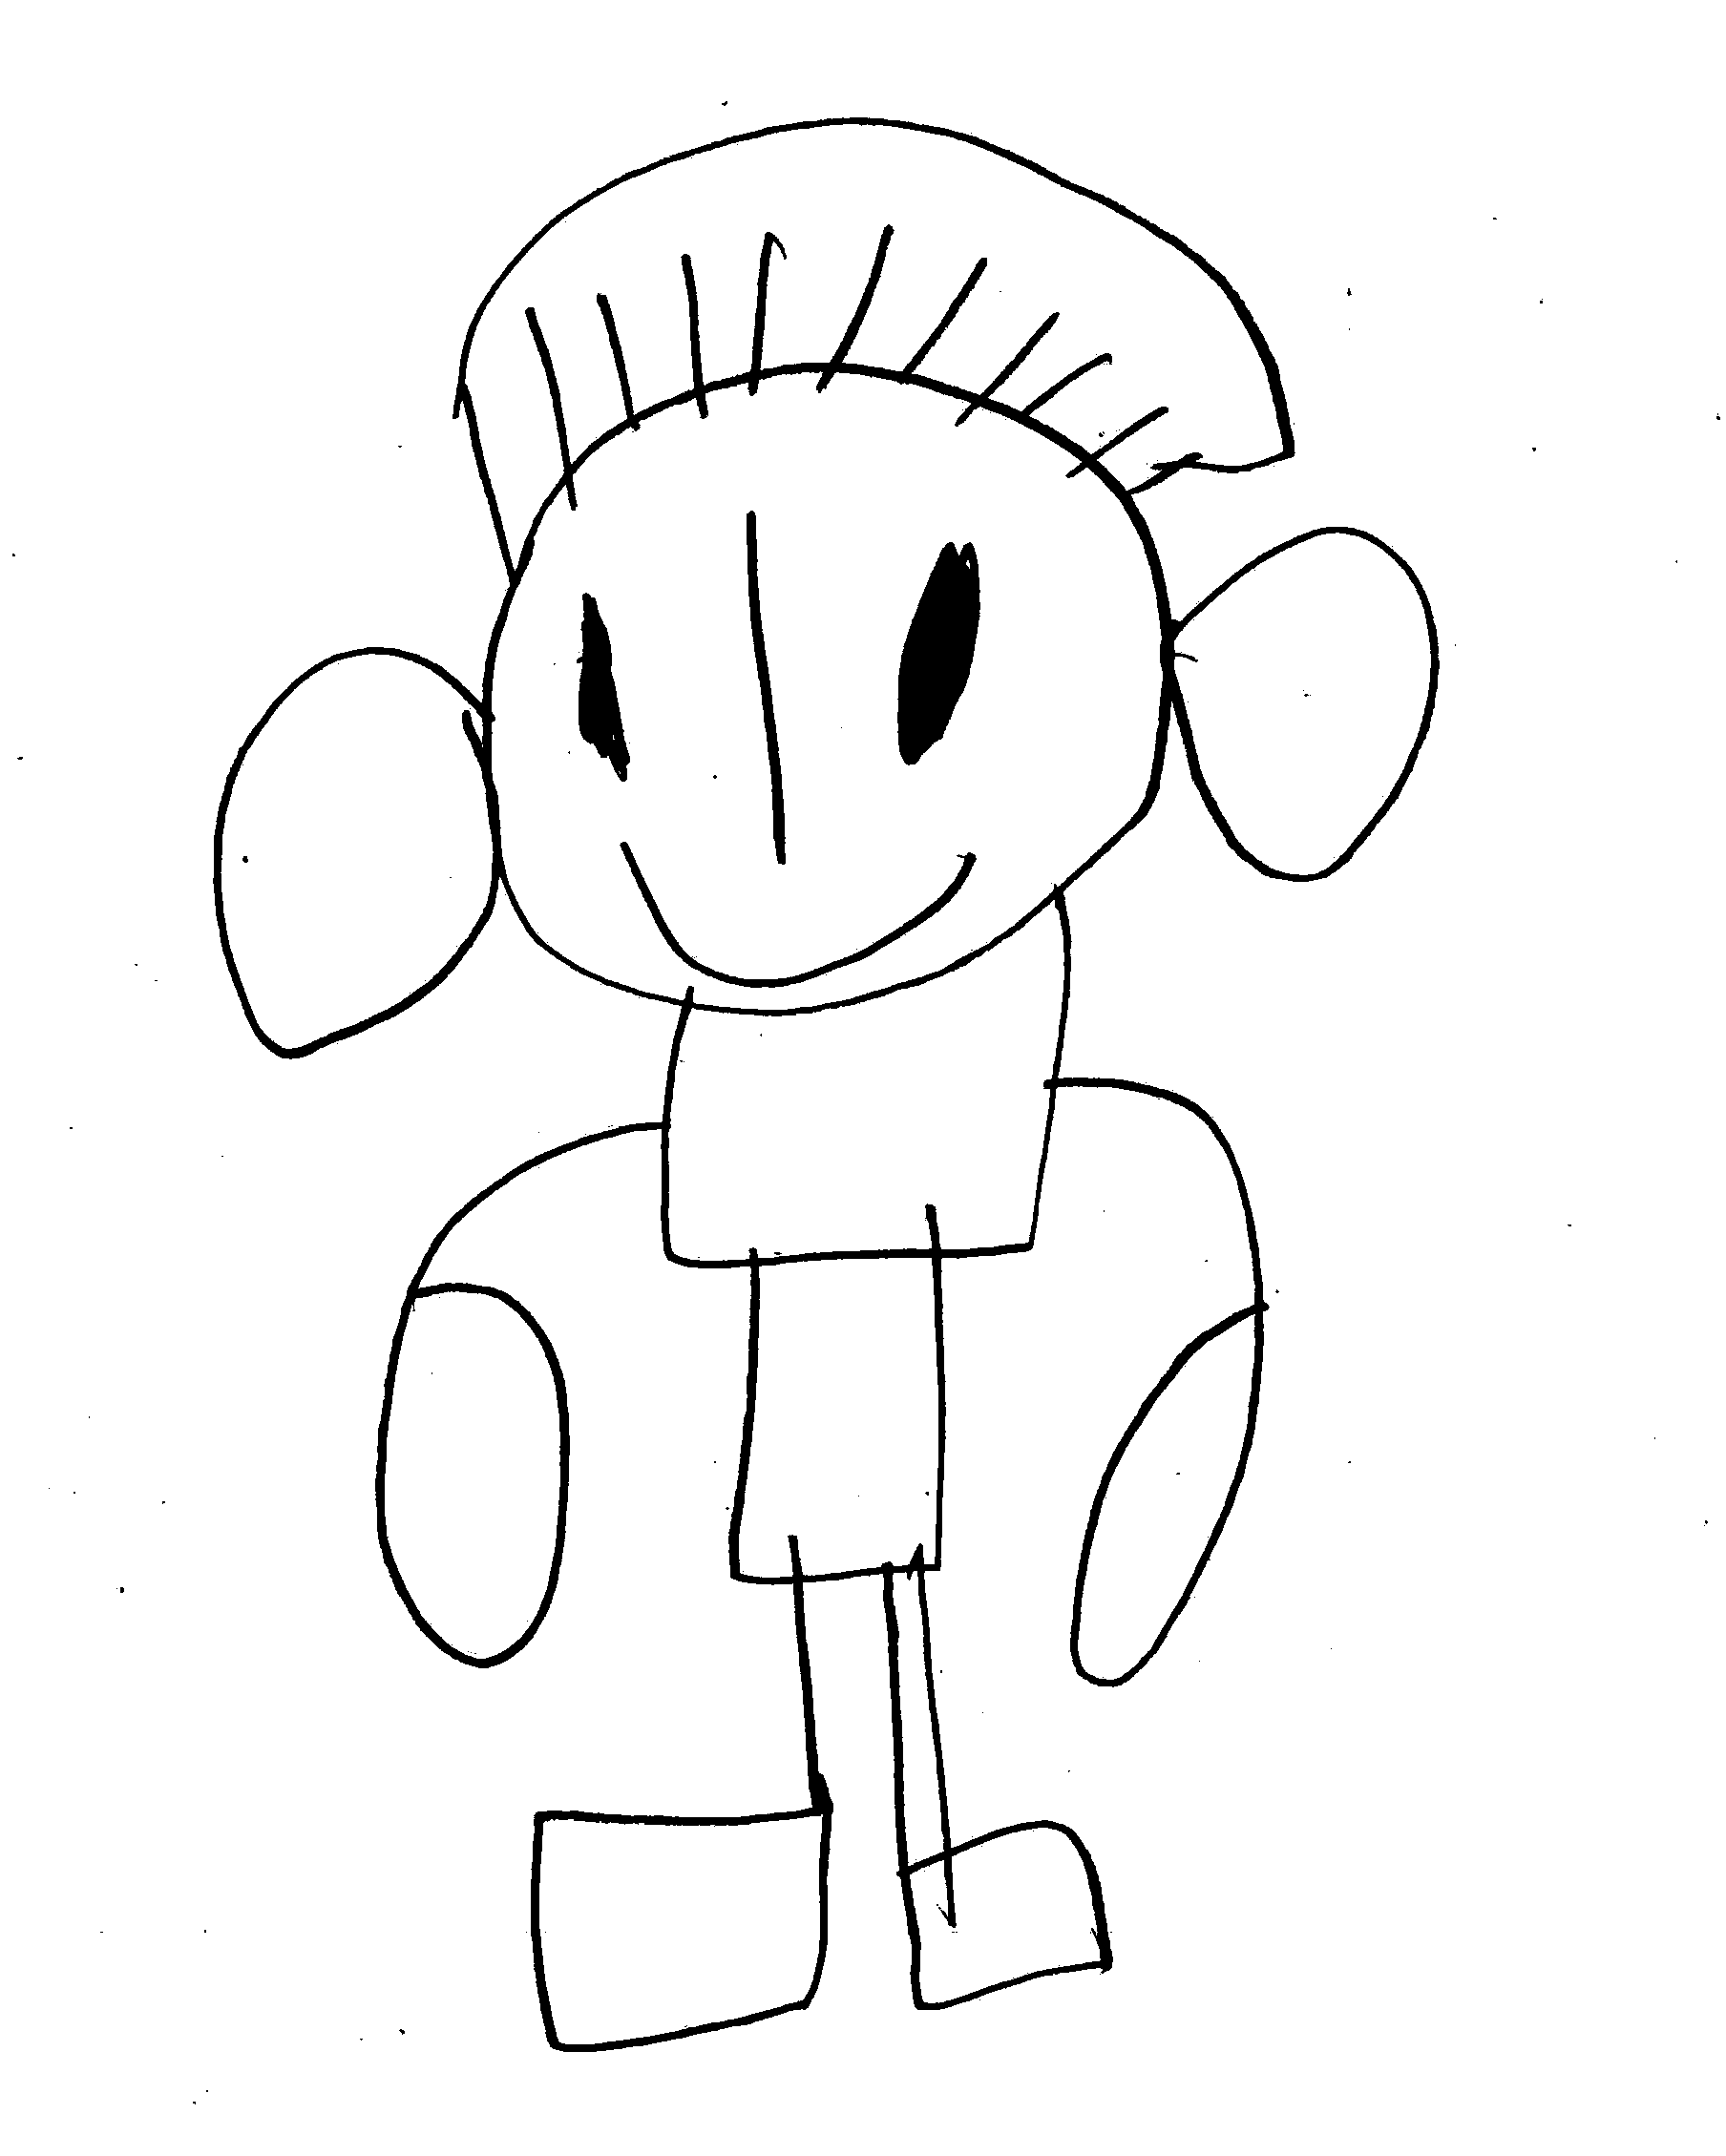

In [13]:
image_path = './A-2-o3.jpg'
image = Image.open(image_path)  #PIL로 이미지 오픈
image = image.convert("L")
image = image.point(lambda p: p > 240 and 255)
image.show()

# Json Open

In [14]:
json_path='./'
json_name = image_path.split('/')[-1].split('.')[0] + ".json" #! image 이름에서 자동으로 parsing
part_json = {}
part_name = ["head", "eye","nose","ear","mouth","hand","foot","upper_body","lower_body","aaa"]
for part in part_name:
    part_json[part]=[]
with open(os.path.join(json_path, json_name), 'r') as f :   
    boxes=json.load(f)['shapes']
    for box in boxes:
        part_json[box["label"]].append(box["points"])
print(part_json)
#! ASD의 경우 xmin, ymin , xmax, ymax
# part_anns = part_json[part] #@ 여기에서 한번에 모든 part 뽑자. 
# coords = [part_anns[0][0], part_anns[0][1], part_anns[1][0], part_anns[1][1]]

{'head': [[[202.5294117647059, 111.85294117647067], [1520.1764705882354, 1123.6176470588234]]], 'eye': [[[570.1764705882352, 608.9117647058823], [696.6470588235294, 838.3235294117648]], [[917.235294117647, 541.2647058823529], [1052.5294117647059, 820.6764705882352]]], 'nose': [[[743.7058823529411, 508.91176470588243], [867.235294117647, 935.3823529411765]]], 'ear': [[[205.47058823529414, 661.8529411764706], [537.8235294117646, 1123.6176470588234]], [[1202.5294117647059, 532.4411764705883], [1514.2941176470588, 938.3235294117648]]], 'mouth': [[[634.8823529411765, 850.0882352941177], [1034.8823529411766, 1053.0294117647059]]], 'hand': [[[381.94117647058823, 1329.5], [614.2941176470588, 1770.6764705882351]], [[1093.7058823529412, 1347.1470588235293], [1340.764705882353, 1785.3823529411761]]], 'foot': [[[543.7058823529411, 1861.8529411764703], [887.8235294117646, 2173.6176470588234]], [[928.9999999999999, 1903.0294117647059], [1179.0, 2123.6176470588234]]], 'upper_body': [[[386.14285714285

# Function


In [15]:
def replace_part(img,image_path,replace_img,part,is_black=False):
    json_path='/data/datasets/asd/asd_all_5folds_annotations'
    json_name = image_path.split('/')[-1].split('.')[0] + ".json"
    part_json = {}
    with open(os.path.join(json_path, json_name), 'r') as f :   
        boxes=json.load(f)['shapes']
        for box in boxes:
            part_json[box["label"]]=box["points"]
    #! 0: 사람 전체 1: 머리 2:얼굴 3:눈 4:눈
        
    part_anns = part_json[part]
    
    coords = [int(part_anns[0][0]), int(part_anns[0][1]), int(part_anns[1][0]), int(part_anns[1][1])]
    xmin, ymin, xmax, ymax = coords
    # xmin, ymin = int(x), int(y)
    # xmax, ymax = int(x + w), int(y + h)
    # print(coords)
    box_region = img.crop(coords)
    black_box = 255*np.ones(box_region.size)
    black_box = Image.fromarray(black_box)
    if box_region.size != replace_img.size:
        replace_img= replace_img.resize(box_region.size)
        black_box = black_box.resize(box_region.size)
        print('replace_part is resized')
    
    if is_black:
        img.paste(black_box,coords)
    else:
        img.paste(replace_img,coords)
    # return sample_img

In [16]:
class shapely_part(Dataset):
    def __init__(self, data_folder, json_folder, binary_thresholding=None, transform=None):
        self.json_folder = json_folder
        self.data_folder = data_folder
        self.binary_thresholding=binary_thresholding
        self.transform = transform
        self.image_paths = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(('.png', '.jpg', '.jpeg', '.gif'))]
        self.json_paths = [image_path.split('/')[-1].split('.')[0] + ".json" for image_path in self.image_paths] #! Get json path from image paths.
        print(self.image_paths)
    def get_part_json(self, json_file_path, part_name):
        '''
        Get part dictionary from json path
        '''
        part_json = {}
        
        for part in part_name:
            part_json[part] = []
        with open(json_file_path, 'r') as f:
            boxes = json.load(f)['shapes']
            for box in boxes:
                part_json[box["label"]].append(box["points"])
    
        for key in part_json:#! 빈 애들은 None으로 처리해서 없다고 판단.
            if not part_json[key]:
                part_json[key] = None

        return part_json
    def get_coords(self, part):
        extracted_coordinates = []
        if part is None:
            return None
        elif len(part) == 1:
            xmin, ymin = list(map(int,part[0][0]))
            xmax, ymax = list(map(int,part[0][1]))
            return [[xmin,ymin,xmax,ymax]]#아래 2일경우와 통일하기 위해 이중 리스트로 
        elif len(part) == 2:
            #! Eye, Ear, hand, foot -> These have 2 part, return list
            for a in part: 
                # print(a)
                xmin, ymin = list(map(int,a[0]))
                xmax, ymax = list(map(int,a[1]))
                extracted_coordinates.append([xmin,ymin,xmax,ymax])
            return extracted_coordinates
        else:
            exit(0)
    def get_white_image(self,size):
        return Image.new("RGB", size, (255, 255, 255))
    def get_empty_face(self,img, part_imgs, part_json):
        '''
        empty_face is face detached 'eye','nose','mouth','ear'
        '''
        head_json = part_json['head']
        head_coords = self.get_coords(head_json)
        head = part_imgs['head'][0]#!
        white_image = self.get_white_image(img.size)
        white_image.paste(head,head_coords[0])
        for part in ['eye','nose','mouth','ear']:
            if part_json[part] is not None:
              part_coords= self.get_coords(part_json[part])
              part_img = part_imgs[part]
              if part in ['eye','ear']:   
                  white_image.paste(self.get_white_image(part_img[0].size),part_coords[0])
                  white_image.paste(self.get_white_image(part_img[1].size),part_coords[1])
              else:
                  white_image.paste(self.get_white_image(part_img[0].size),part_coords[0])
                  
        return white_image 
    def get_empty_face(self,img, part_imgs, part_json):
        '''
        empty_face is face detached 'eye','nose','mouth','ear'
        '''
        head_json = part_json['head']
        head_coords = self.get_coords(head_json)
        head = part_imgs['head'][0]#!
        white_image = self.get_white_image(img.size)
        white_image.paste(head,head_coords[0])
        for part in ['eye','nose','mouth','ear']:
            if part_json[part] is not None:
              part_coords= self.get_coords(part_json[part])
              part_img = part_imgs[part]
              if part in ['eye','ear']:   
                  white_image.paste(self.get_white_image(part_img[0].size),part_coords[0])
                  white_image.paste(self.get_white_image(part_img[1].size),part_coords[1])
              else:
                  white_image.paste(self.get_white_image(part_img[0].size),part_coords[0])
        # white_image.show()
        return white_image
    def get_empty_lower_body(self,img, part_imgs, part_json):
        '''
        empty_lower_body detacched foot
        '''
        lower_body_json = part_json['lower_body']
        lower_body_coords = self.get_coords(lower_body_json)
        lower_body = part_imgs['lower_body'][0]#!
        white_image = self.get_white_image(img.size)
        white_image.paste(lower_body,lower_body_coords[0])
        if part_json["foot"] is not None:
            part_coords= self.get_coords(part_json["foot"])
            part_img = part_imgs["foot"] 
            white_image.paste(self.get_white_image(part_img[0].size),part_coords[0])
            white_image.paste(self.get_white_image(part_img[1].size),part_coords[1])
        
        return white_image.crop(lower_body_coords[0])
    def get_empty_upper_body(self,img, part_imgs, part_json):
        '''
        empty_lower_body detacched foot
        '''
        upper_body_json = part_json['upper_body']
        upper_body_coords = self.get_coords(upper_body_json)
        upper_body = part_imgs['upper_body'][0]#!
        white_image = self.get_white_image(img.size)
        white_image.paste(upper_body,upper_body_coords[0])
        if part_json["hand"] is not None:
            part_coords= self.get_coords(part_json["hand"])
            part_img = part_imgs["hand"] 
            white_image.paste(self.get_white_image(part_img[0].size),part_coords[0])
            white_image.paste(self.get_white_image(part_img[1].size),part_coords[1])
        # white_image.crop(upper_body_coords[0]).show()
        return white_image.crop(upper_body_coords[0])
    
    def create_new_images(self,img, binary_combination, part_imgs ):
        #! Making New images
        original_img = img
        empty_face_active, eye_active, nose_active, ear_active, mouth_active, hand_active, foot_active = binary_combination
        # New white image

        new_image = self.get_white_image(original_img.size)
        if empty_face_active:
            new_image.paste(part_imgs["empty_face"][0],(0,0))
        new_image.paste(part_imgs["empty_lower_body"][0], self.get_coords(part_json['lower_body'])[0])  # 원하는 위치에 붙임
        new_image.paste(part_imgs["empty_upper_body"][0], self.get_coords(part_json['upper_body'])[0])  # 원하는 위치에 붙임
        # 각 파트 이미지를 읽어와서 새로운 이미지에 붙임
        if eye_active and part_imgs["eye"] is not None:
            new_image.paste(part_imgs["eye"][0], self.get_coords(part_json['eye'])[0])  # 원하는 위치에 붙임
            new_image.paste(part_imgs["eye"][1], self.get_coords(part_json['eye'])[1])  # 원하는 위치에 붙임 
        if nose_active and part_imgs["nose"] is not None:
            new_image.paste(part_imgs["nose"][0], self.get_coords(part_json['nose'])[0])  # 원하는 위치에 붙임 
        if ear_active and part_imgs["ear"] is not None:
            new_image.paste(part_imgs["ear"][0], self.get_coords(part_json['ear'])[0])  # 원하는 위치에 붙임 
            new_image.paste(part_imgs["ear"][1], self.get_coords(part_json['ear'])[1])  # 원하는 위치에 붙임 
        if mouth_active and part_imgs["mouth"] is not None:
            new_image.paste(part_imgs["mouth"][0], self.get_coords(part_json['mouth'])[0])  # 원하는 위치에 붙임 
        if hand_active and part_imgs["hand"] is not None:
            new_image.paste(part_imgs["hand"][0], self.get_coords(part_json['hand'])[0])  # 원하는 위치에 붙임 
            new_image.paste(part_imgs["hand"][1], self.get_coords(part_json['hand'])[1])  # 원하는 위치에 붙임 
        if foot_active and part_imgs["foot"] is not None:
            new_image.paste(part_imgs["foot"][0], self.get_coords(part_json['foot'])[0])  # 원하는 위치에 붙임 
            new_image.paste(part_imgs["foot"][1], self.get_coords(part_json['foot'])[1])  # 원하는 위치에 붙임 
        # 다른 파트들에 대해서도 같은 방식으로 처리
        return new_image
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        label = 0 if (img_path.split('/')[-1].split('.')[0].split('-')[0])=='A' else 1
        image = Image.open(img_path)
        part_name = ["head", "eye", "nose", "ear", "mouth", "hand", "foot", "upper_body", "lower_body"]
        if self.binary_thresholding:
            image = image.convert("L")#! Convert grayscale
            image = image.point(lambda p: p > self.binary_thresholding and 255)
        part_json = self.get_part_json(self.json_paths[idx],part_name=part_name)
        part_imgs = {}
        for part in part_name:#모든 part를 다시 dict으로 리턴하기위함.
            part_imgs[part]=[]
            # print(part)
            coords = self.get_coords(part_json[part])
            # print(coords)
            if coords is None:
                part_imgs[part].append(None)    
                
            elif len(coords) ==1:
                part_imgs[part].append(image.crop(coords[0]))    
            elif len(coords) == 2:
                part_imgs[part].append(image.crop(coords[0]))    
                part_imgs[part].append(image.crop(coords[1]))    
        empty_face = self.get_empty_face(image,part_imgs,part_json)
        # empty_face.show()
        empty_upper_body = self.get_empty_upper_body(image,part_imgs,part_json)
        empty_lower_body = self.get_empty_lower_body(image,part_imgs,part_json)
        part_imgs['empty_face']=[empty_face]
        part_imgs['empty_lower_body']=[empty_lower_body]
        part_imgs['empty_upper_body']=[empty_upper_body]
        part_combinations = list(itertools.product([0, 1], repeat=7))
        new_imgs = []
        for combination in part_combinations:
            # print(combination)
            new_img=self.create_new_images(img=image,binary_combination=combination, part_imgs=part_imgs)
            new_imgs.append(new_img)
        return part_imgs,label,part_json, new_imgs

In [17]:
dataset = shapely_part('./','./',240)

['./A-2-o3.jpg', './B-2-o3_2.jpg', './A-2-o3_2.jpg']


0


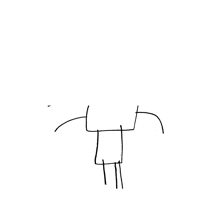

1


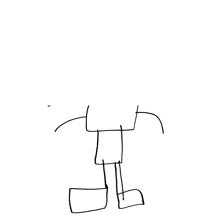

2


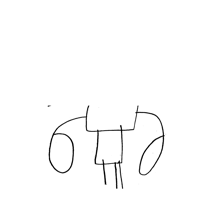

3


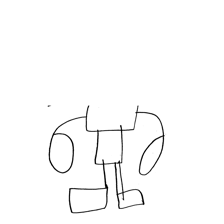

4


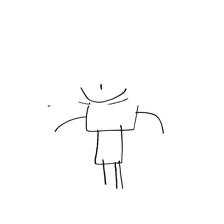

5


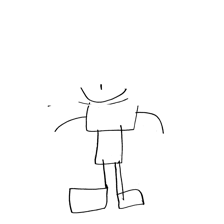

6


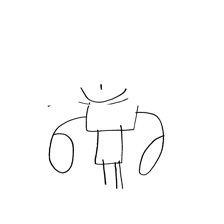

7


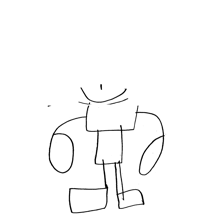

8


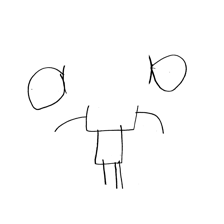

9


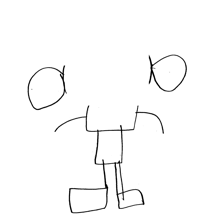

10


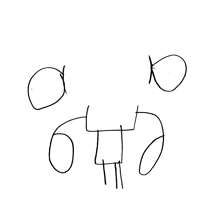

11


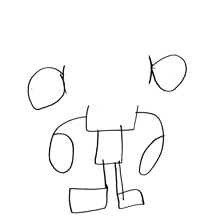

12


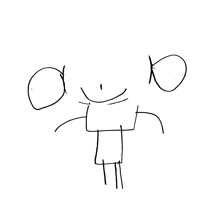

13


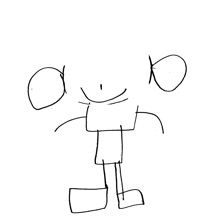

14


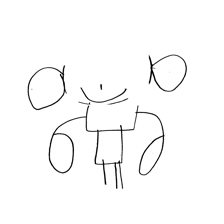

15


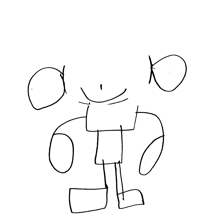

16


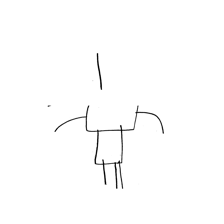

17


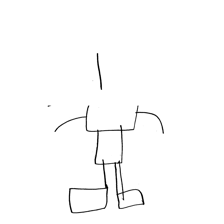

18


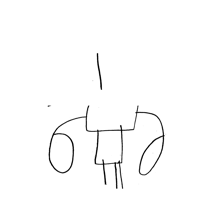

19


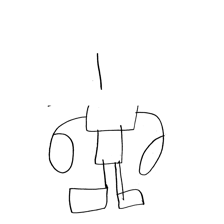

20


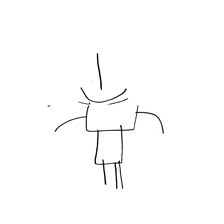

21


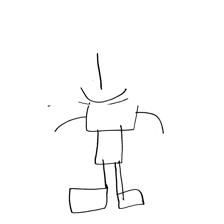

22


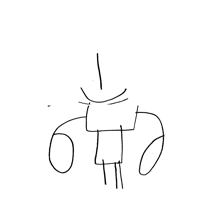

23


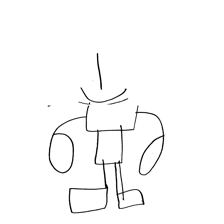

24


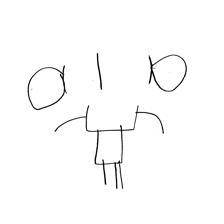

25


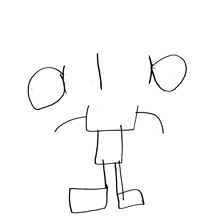

26


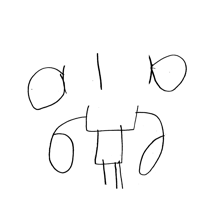

27


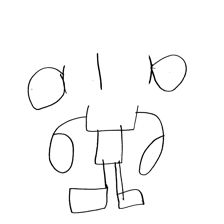

28


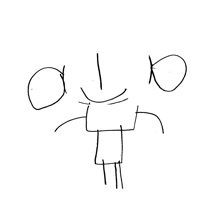

29


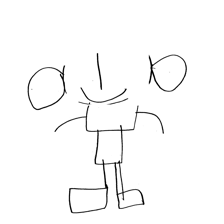

30


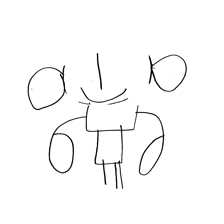

31


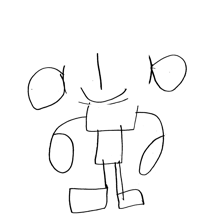

32


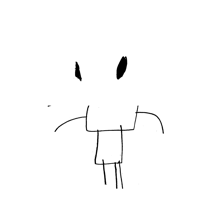

33


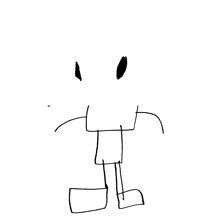

34


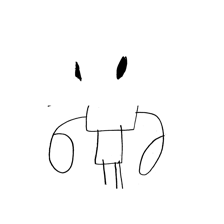

35


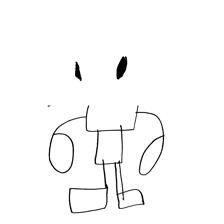

36


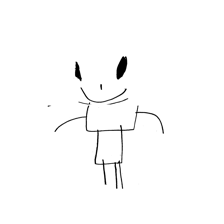

37


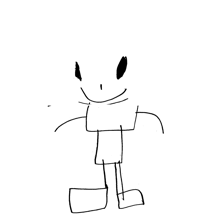

38


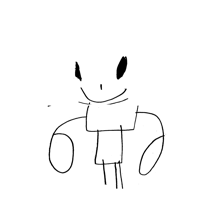

39


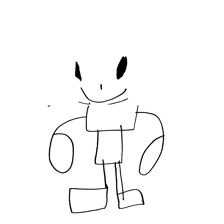

40


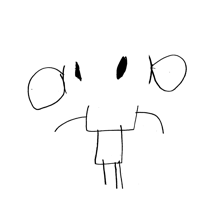

41


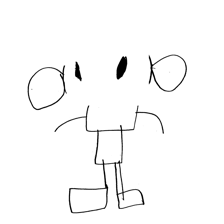

42


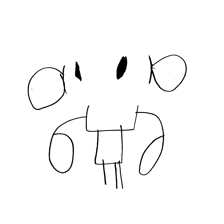

43


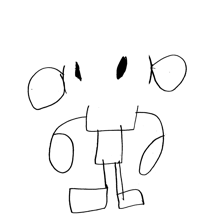

44


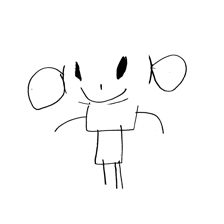

45


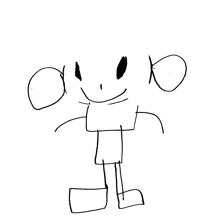

46


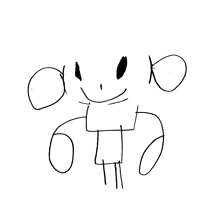

47


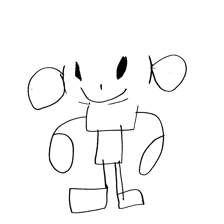

48


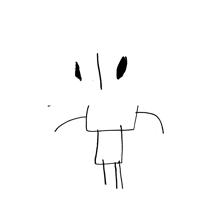

49


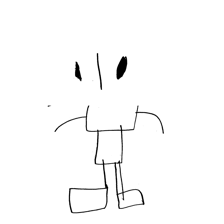

50


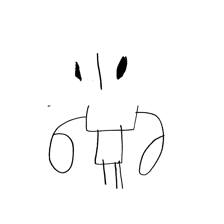

51


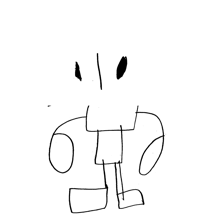

52


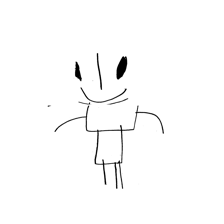

53


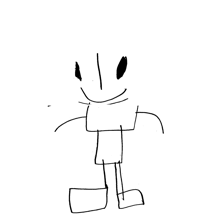

54


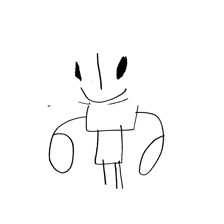

55


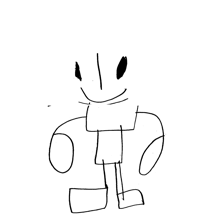

56


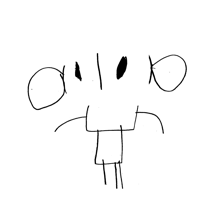

57


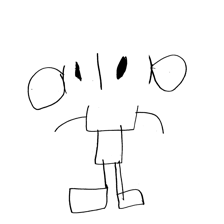

58


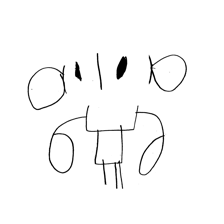

59


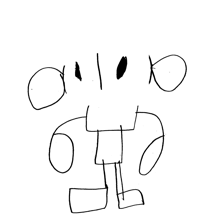

60


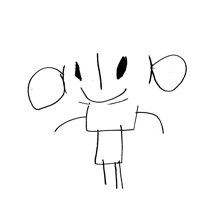

61


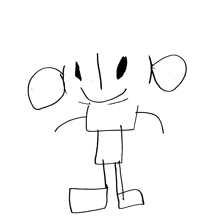

62


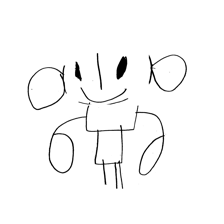

63


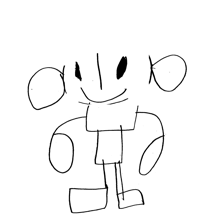

64


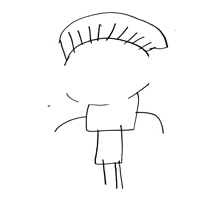

65


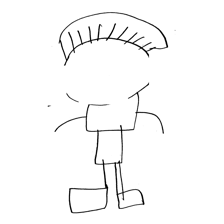

66


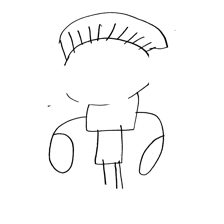

67


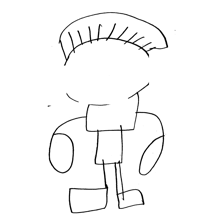

68


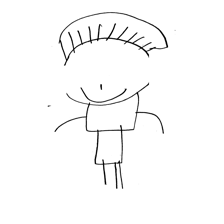

69


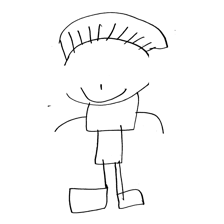

70


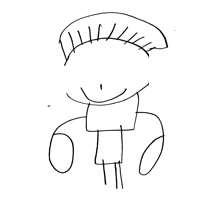

71


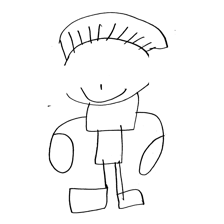

72


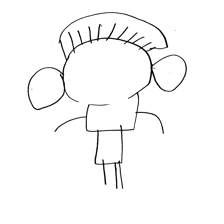

73


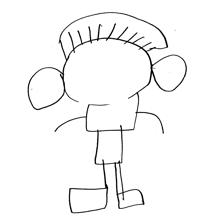

74


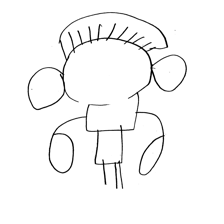

75


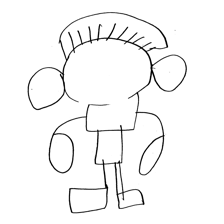

76


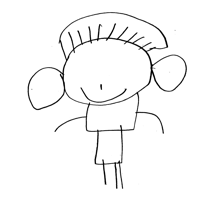

77


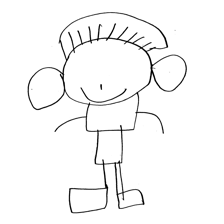

78


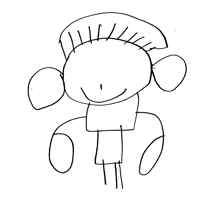

79


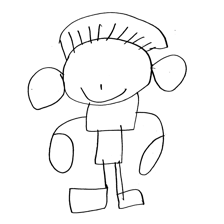

80


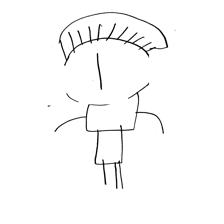

81


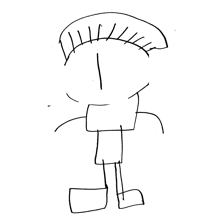

82


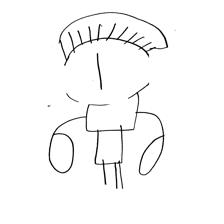

83


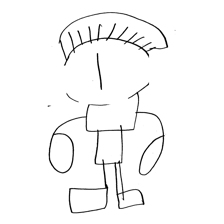

84


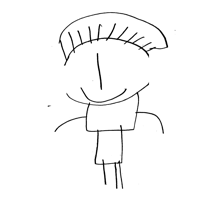

85


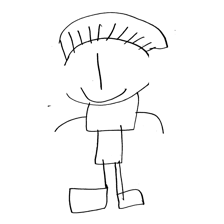

86


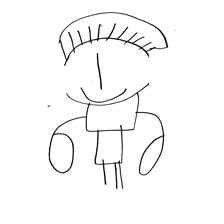

87


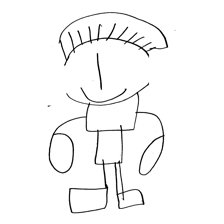

88


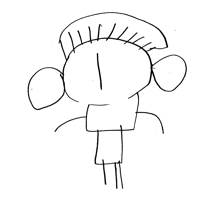

89


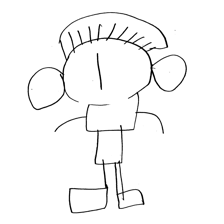

90


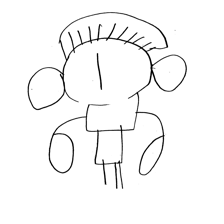

91


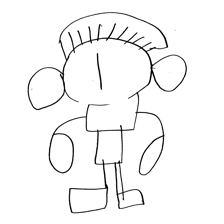

92


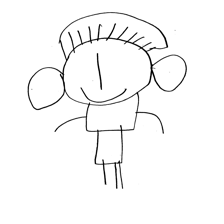

93


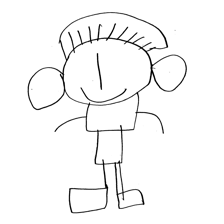

94


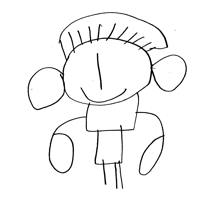

95


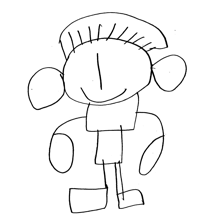

96


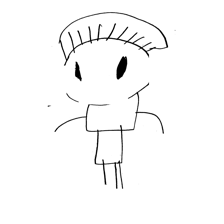

97


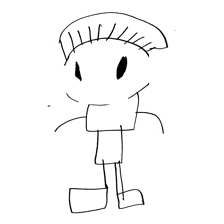

98


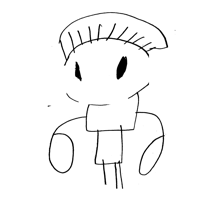

99


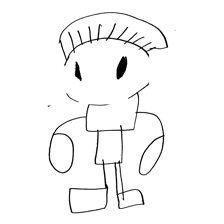

100


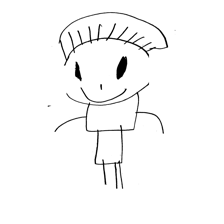

101


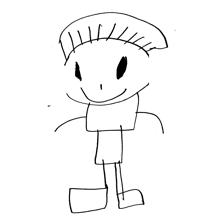

102


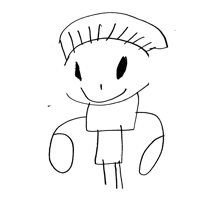

103


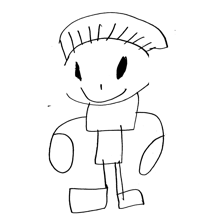

104


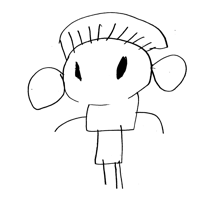

105


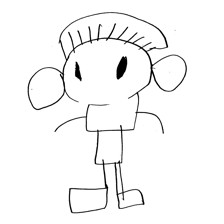

106


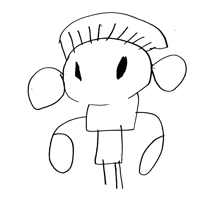

107


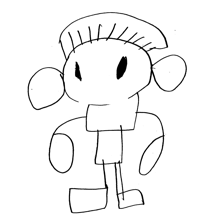

108


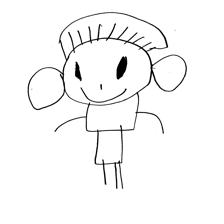

109


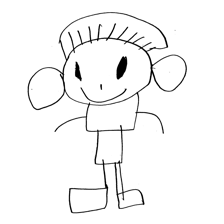

110


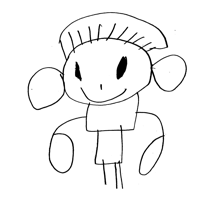

111


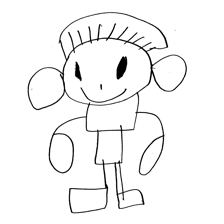

112


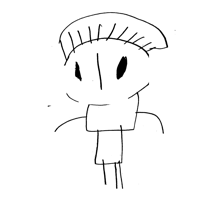

113


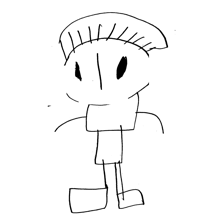

114


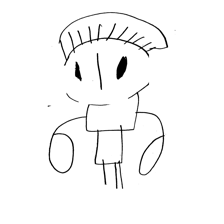

115


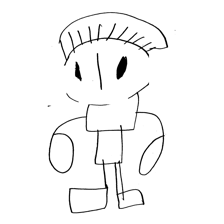

116


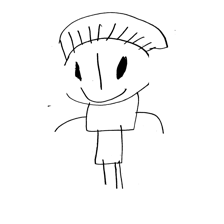

117


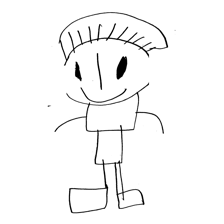

118


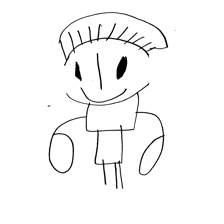

119


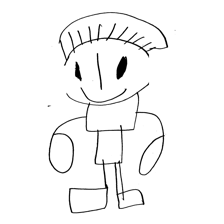

120


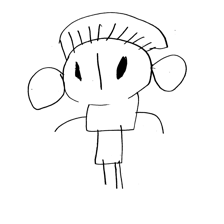

121


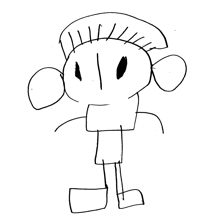

122


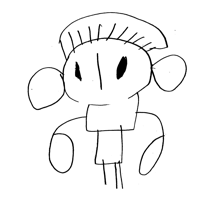

123


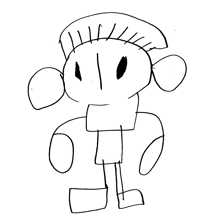

124


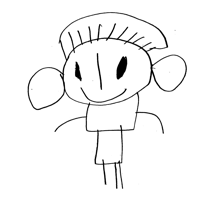

125


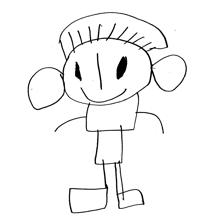

126


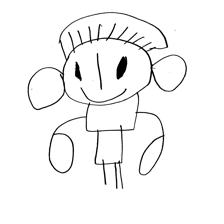

127


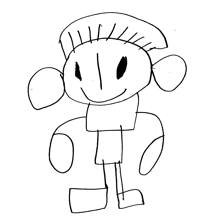

In [19]:
for i in range(128):
    print(i)
    dataset[0][3][i].resize((224,224)).show()

In [20]:
part_combinations = list(itertools.product([0, 1], repeat=7))

In [21]:
part_combinations

[(0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 1),
 (0, 0, 0, 0, 0, 1, 0),
 (0, 0, 0, 0, 0, 1, 1),
 (0, 0, 0, 0, 1, 0, 0),
 (0, 0, 0, 0, 1, 0, 1),
 (0, 0, 0, 0, 1, 1, 0),
 (0, 0, 0, 0, 1, 1, 1),
 (0, 0, 0, 1, 0, 0, 0),
 (0, 0, 0, 1, 0, 0, 1),
 (0, 0, 0, 1, 0, 1, 0),
 (0, 0, 0, 1, 0, 1, 1),
 (0, 0, 0, 1, 1, 0, 0),
 (0, 0, 0, 1, 1, 0, 1),
 (0, 0, 0, 1, 1, 1, 0),
 (0, 0, 0, 1, 1, 1, 1),
 (0, 0, 1, 0, 0, 0, 0),
 (0, 0, 1, 0, 0, 0, 1),
 (0, 0, 1, 0, 0, 1, 0),
 (0, 0, 1, 0, 0, 1, 1),
 (0, 0, 1, 0, 1, 0, 0),
 (0, 0, 1, 0, 1, 0, 1),
 (0, 0, 1, 0, 1, 1, 0),
 (0, 0, 1, 0, 1, 1, 1),
 (0, 0, 1, 1, 0, 0, 0),
 (0, 0, 1, 1, 0, 0, 1),
 (0, 0, 1, 1, 0, 1, 0),
 (0, 0, 1, 1, 0, 1, 1),
 (0, 0, 1, 1, 1, 0, 0),
 (0, 0, 1, 1, 1, 0, 1),
 (0, 0, 1, 1, 1, 1, 0),
 (0, 0, 1, 1, 1, 1, 1),
 (0, 1, 0, 0, 0, 0, 0),
 (0, 1, 0, 0, 0, 0, 1),
 (0, 1, 0, 0, 0, 1, 0),
 (0, 1, 0, 0, 0, 1, 1),
 (0, 1, 0, 0, 1, 0, 0),
 (0, 1, 0, 0, 1, 0, 1),
 (0, 1, 0, 0, 1, 1, 0),
 (0, 1, 0, 0, 1, 1, 1),
 (0, 1, 0, 1, 0, 0, 0),
 (0, 1, 0, 1, 0,